In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import keras.backend as K

In [ ]:
alpha = np.load("/Users/User/Documents/Inverse Design of Metamaterials/Data/alpha.npy")
print(alpha.shape)

(98171,)


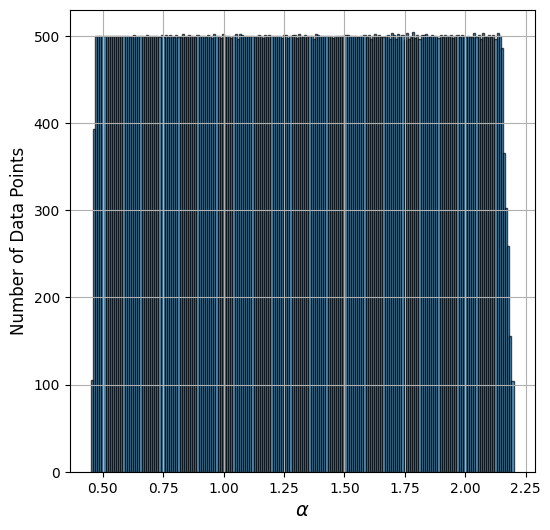

In [ ]:
bin_edges = np.arange(0.5, 2.01, 0.01)  # bins from 0.5 to 2.0 with a width of 0.01

# Plot histogram
plt.figure(figsize=(6, 6))
plt.hist(alpha, bins=200, edgecolor='k', alpha=0.7)
plt.xlabel(r'$\alpha$', fontsize=14)
plt.ylabel('Number of Data Points', fontsize=12)
#plt.title('Histogram of Data Points in Bins', fontsize=11)
#.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()

In [ ]:
image_dataset = np.load("/Users/User/Documents/Inverse Design of Metamaterials/Data/images.npy")
image_dataset = image_dataset.reshape(98171, 29, 29, 1)
print(image_dataset.shape)

(98171, 29, 29, 1)


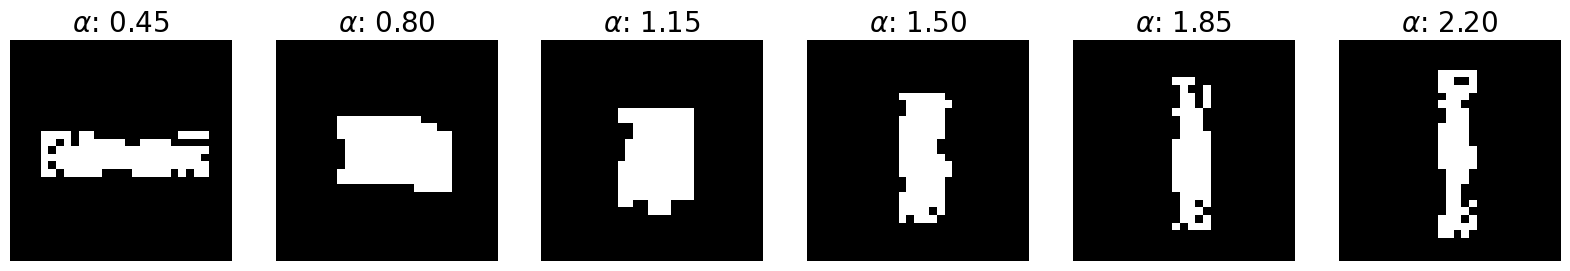

In [ ]:
def sample_uniform_alpha(alpha_values, num_samples=6):
    min_alpha = np.min(alpha_values)
    max_alpha = np.max(alpha_values)
    sampled_alphas = np.linspace(min_alpha, max_alpha, num_samples)

    closest_indices = []
    for alpha in sampled_alphas:
        closest_index = np.argmin(np.abs(alpha_values - alpha))
        closest_indices.append(closest_index)

    return closest_indices

def display_images(images, indices, alpha_values):
    fig, axes = plt.subplots(1, len(indices), figsize=(20, 5))
    for ax, idx in zip(axes, indices):
        ax.imshow(images[idx].reshape(29, 29), cmap='gray')  # Adjust the shape as per your image dimensions
        ax.set_title(r'$\alpha$: {:.2f}'.format(alpha_values[idx]), fontsize=20)
        ax.axis('off')
    plt.show()

# Assuming image_train and alpha_train are your training images and alpha values respectively
# image_train is a numpy array of shape (num_samples, height, width) or (num_samples, height, width, channels)
# alpha_train is a numpy array of shape (num_samples,)

# Find the indices of the sampled alphas
indices = sample_uniform_alpha(alpha)

# Display the corresponding images
display_images(image_dataset, indices, alpha)

In [ ]:
image_train, image_test, alpha_train, alpha_test = train_test_split(
    image_dataset, alpha, test_size=0.2, random_state=42
)

In [ ]:
image_train, image_val, alpha_train, alpha_val = train_test_split(
    image_train, alpha_train, test_size=0.5, random_state=42
)

In [ ]:
model1 = models.Sequential(name = 'Forward')
model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(29, 29, 1)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(16, activation='relu'))  # Assuming a 4x4 stiffness matrix
model1.add(layers.Dense(16))# Output layer for stiffness matrix
model1.add(layers.Dense(1))
model1.trainable = False

In [ ]:
model1.load_weights('/Users/User/Documents/Inverse Design of Metamaterials/Data/alpha_prediction_weights.h5')

In [ ]:
def build_encoder(input_shape, property_shape, latent_dim):
    inputs = tf.keras.Input(shape=input_shape)
    #alpha = tf.keras.Input(shape=property_shape)
    x = layers.Conv2D(32, 3, activation='relu', strides=1, padding='same')(inputs)
    x = layers.Conv2D(64, 3, activation='relu', strides=1, padding='same')(x)
    x = layers.Flatten()(x)
    #x = layers.Concatenate()([x, alpha])
    x = layers.Dense(16, activation='relu')(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

    z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    encoder = tf.keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder

In [ ]:
def build_decoder(latent_dim, property_shape, output_shape):
    latent_inputs = tf.keras.Input(shape=(latent_dim,))
    alpha = tf.keras.Input(shape=property_shape)
    x = layers.Concatenate()([latent_inputs, alpha])
    x = layers.Dense(8 * 8 * 64, activation='relu')(x)
    x = layers.Reshape((8, 8, 64))(x)

    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(64, 3, activation='relu', strides=1, padding='same')(x)

    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(32, 3, activation='relu', strides=1, padding='same')(x)

    x = layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)

    # Combine the cropping into one layer
    outputs = layers.Cropping2D(cropping=((3, 0), (3, 0)))(x)

    decoder = tf.keras.Model([latent_inputs, alpha], outputs, name='decoder')
    #decoder.summary()
    return decoder



In [ ]:
# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
def alpha_penalty(predicted_alpha, true_alpha, lower_bound=1, upper_bound=1.6, deviation_threshold=0, penalty_weight=200):
    deviation = tf.abs(predicted_alpha - true_alpha)
    outside_bounds = tf.logical_or(true_alpha < lower_bound, true_alpha > upper_bound)
    high_deviation = deviation > deviation_threshold
    penalty = penalty_weight * tf.reduce_mean(tf.cast(tf.logical_and(outside_bounds, high_deviation), tf.float32) * deviation)
    #print(penalty)
    return penalty

In [ ]:
def vae_loss(inputs, outputs, z_mean, z_log_var, input_shape, alpha_true, alpha_pred, recon_weight=1, kl_weight=1, penalty_weight=200):
    reconstruction_loss = tf.keras.losses.binary_crossentropy(K.flatten(inputs), K.flatten(outputs))
    reconstruction_loss *= np.prod(input_shape)

    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_sum(kl_loss, axis=-1)
    kl_loss *= -0.5

    penalty = alpha_penalty(alpha_pred, alpha_true, penalty_weight=penalty_weight)

    total_vae_loss = tf.reduce_mean((recon_weight * reconstruction_loss) + (kl_weight * kl_loss) + penalty)
    #print(penalty)
    return total_vae_loss, reconstruction_loss, kl_loss, penalty

In [ ]:
def build_vae(encoder, decoder, input_shape, property_shape, latent_dim, penalty_weight):
    image = tf.keras.Input(shape=input_shape)
    alpha = tf.keras.Input(shape=property_shape)
    z_mean, z_log_var, z = encoder([image, alpha])
    outputs = decoder([z, alpha])
    predicted_alpha = model1(outputs)  # Assuming model1 is your alpha prediction model

    total_loss, recon_loss, kl_loss, penalty = vae_loss(image, outputs, z_mean, z_log_var, input_shape, alpha, predicted_alpha, penalty_weight=penalty_weight)

    vae = tf.keras.Model([image, alpha], outputs, name='vae')
    vae.add_loss(total_loss)

    vae.add_metric(recon_loss, name='reconstruction_loss', aggregation='mean')
    vae.add_metric(kl_loss, name='kl_loss', aggregation='mean')
    vae.add_metric(penalty, name='penalty', aggregation='mean')

    return vae

In [ ]:
def compile_and_train_vae(vae, train_data, property_train, val_data, property_val, epochs=100, batch_size=32):
    vae.compile(optimizer='adam')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = vae.fit(
        [train_data, property_train], epochs=epochs, batch_size=batch_size,
        callbacks=early_stopping, validation_data=([val_data, property_val], None)
    )

    # Plot a loss chart
    fig, ax = plt.subplots(1, 3, figsize=(24, 8))

    ax[0].plot(history.history['loss'], label='Training Loss', color='blue')
    ax[0].plot(history.history['val_loss'], label='Validation Loss', color='orange')
    ax[0].set(xlabel='Epoch', ylabel='Total Loss')
    ax[0].set_title('Total Loss')
    ax[0].legend()

    ax[1].plot(history.history['reconstruction_loss'], label='Training Loss', color='blue')
    ax[1].plot(history.history['val_reconstruction_loss'], label='Validation Loss', color='orange')
    ax[1].set(xlabel='Epoch', ylabel='Reconstruction Loss')
    ax[1].set_title('Reconstruction Loss')
    ax[1].legend()

    ax[2].plot(history.history['kl_loss'], label='Trainin Loss', color='blue')
    ax[2].plot(history.history['val_kl_loss'], label='Validation Loss', color='orange')
    ax[2].set(xlabel='Epoch', ylabel='KL Loss')
    ax[2].set_title('KL Loss')
    ax[2].legend()


    plt.show()
    return history

In [ ]:
# Build and train the VAE
input_shape = (29, 29, 1)
property_shape = (1,)
latent_dim = 2
penalty_weight = 200  # Adjust this weight based on how strongly you want to penalize deviations

encoder = build_encoder(input_shape, property_shape, latent_dim)
decoder = build_decoder(latent_dim, property_shape, input_shape)
#vae = build_vae(encoder, decoder, input_shape, property_shape, latent_dim, penalty_weight)
#train1 = compile_and_train_vae(vae, image_train, alpha_train, image_val, alpha_val)


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Assuming you have already built your models named `encoder`, `decoder`, and `vae`

# Visualize the encoder architecture
plot_model(decoder, to_file='/content/drive/MyDrive/CVAE_decoder.png', show_shapes=True, show_layer_names=False, show_layer_activations=True)
print("Encoder model architecture has been saved to CVAE_decoder.png")


Encoder model architecture has been saved to CVAE_decoder.png


Epoch 1/100
1228/1228 [==============================] - 15s 10ms/step - loss: 81.8566 - reconstruction_loss: 76.0719 - kl_loss: 5.7853 - penalty: 0.0000e+00 - val_loss: 59.3809 - val_reconstruction_loss: 54.7268 - val_kl_loss: 4.6548 - val_penalty: 0.0000e+00
Epoch 2/100
1228/1228 [==============================] - 11s 9ms/step - loss: 57.6010 - reconstruction_loss: 53.1884 - kl_loss: 4.4132 - penalty: 0.0000e+00 - val_loss: 55.4560 - val_reconstruction_loss: 51.3873 - val_kl_loss: 4.0692 - val_penalty: 0.0000e+00
Epoch 3/100
1228/1228 [==============================] - 11s 9ms/step - loss: 54.6834 - reconstruction_loss: 50.6662 - kl_loss: 4.0173 - penalty: 0.0000e+00 - val_loss: 53.1052 - val_reconstruction_loss: 49.1572 - val_kl_loss: 3.9483 - val_penalty: 0.0000e+00
Epoch 4/100
1228/1228 [==============================] - 11s 9ms/step - loss: 53.0404 - reconstruction_loss: 49.1768 - kl_loss: 3.8638 - penalty: 0.0000e+00 - val_loss: 51.9996 - val_reconstruction_loss: 48.2523 - val_k

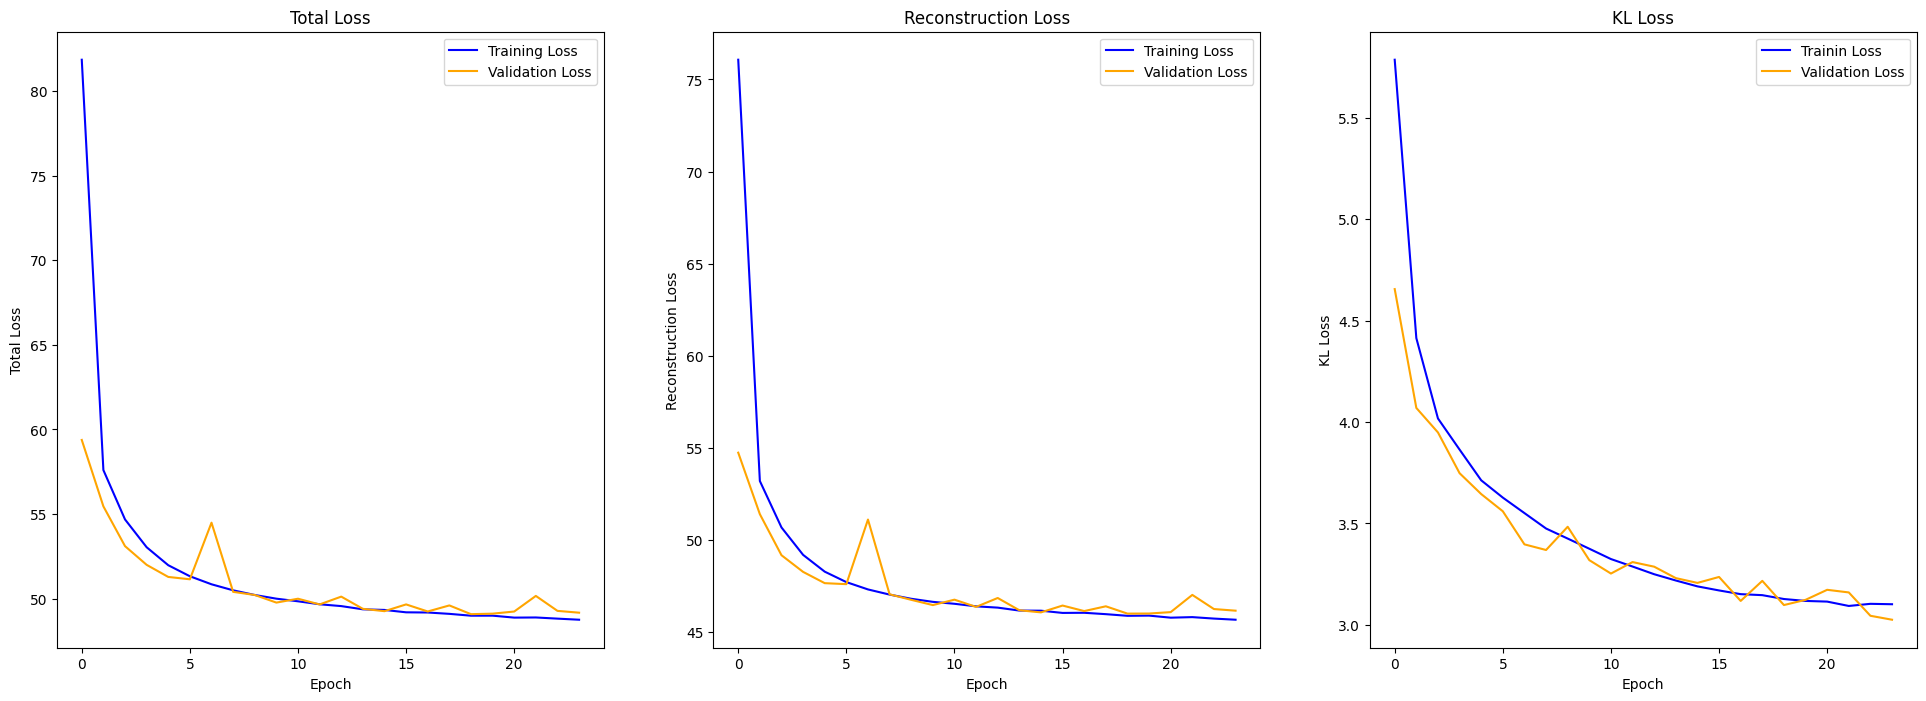

In [ ]:
# Build and train the VAE
input_shape = (29, 29, 1)
property_shape = (1,)
latent_dim = 2
penalty_weight = 0  # Adjust this weight based on how strongly you want to penalize deviations

encoder = build_encoder(input_shape, property_shape, latent_dim)
decoder = build_decoder(latent_dim, property_shape, input_shape)
vae = build_vae(encoder, decoder, input_shape, property_shape, latent_dim, penalty_weight)
train2 = compile_and_train_vae(vae, image_train, alpha_train, image_val, alpha_val)
